In [184]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset

In [186]:
# Black Sea Sprat: 0
# Gilt-Head Bream: 1
# Hourse Mackerel: 2
# Red Mullet: 3
# Red Sea Bream: 4
# Sea Bass: 5
# Shrimp: 6
# Striped Red Mullet: 7
# Trout: 8
# 각 특성에 맞도록, 1000개의 데이터를 만들어보자
import os
from PIL import Image
import numpy as np

fish_list=["Black Sea Sprat", "Gilt-Head Bream", "Hourse Mackerel", "Red Mullet", "Red Sea Bream", "Sea Bass", "Shrimp", "Striped Red Mullet", "Trout"]

feature = np.array([])
target = np.array([])

for j, v in enumerate(fish_list):
    directory = f"../DATA/Fish_Dataset/{v}"
    extension = ".png"
    num_images = 1000
    images = []
    for i in range(1, num_images + 1):
        filename = os.path.join(directory, f"{i:05}"+extension)
        img = Image.open(filename)
        img_resized = img.resize((100, 150))  # 이미지 크기를 100x100으로 조정
        img_array = np.array(img_resized)
        images.append(img_array)

    images_array = np.array(images)

    target_sub = np.array([j for _ in range(1000)])  # 해당 물고기에 대한 라벨 생성
    feature_sub = images_array.reshape(1000, -1)

    if j >= 1:
        feature = np.concatenate((feature, feature_sub), axis=0)
        target = np.concatenate((target, target_sub), axis=0)
    else:
        feature = feature_sub
        target = target_sub

    print(feature.shape, target.shape)


(1000, 15000) (1000,)
(2000, 15000) (2000,)
(3000, 15000) (3000,)
(4000, 15000) (4000,)
(5000, 15000) (5000,)
(6000, 15000) (6000,)
(7000, 15000) (7000,)
(8000, 15000) (8000,)
(9000, 15000) (9000,)


In [187]:
pd.DataFrame(feature.astype("int8")).to_pickle("feature.pkl")
pd.DataFrame(target.astype("int8")).to_pickle("target.pkl")

In [188]:
feature = pd.read_pickle("feature.pkl")
target = pd.read_pickle("target.pkl")

In [189]:
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.1, random_state=42, stratify=target)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.1, random_state=42, stratify=y_test)

In [190]:
x_train.shape, x_valid.shape, x_test.shape

((8100, 15000), (810, 15000), (90, 15000))

In [191]:
x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
x_valid = torch.tensor(x_valid.values, dtype=torch.float32)
y_valid = torch.tensor(y_valid.values, dtype=torch.long)
x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [192]:
# 데이터셋 생성
import torch.utils.data.dataloader as dataloader
import torch.utils.data.dataset as dataset

class MyDataset(dataset.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [193]:
dataset_train = MyDataset(x_train, y_train)
dataset_test = MyDataset(x_test, y_test)
dataset_valid = MyDataset(x_valid, y_valid)

In [194]:
x_train.shape

torch.Size([8100, 15000])

In [195]:
class model(nn.Module): # 가중치 초기화 
    def __init__(self):
        super(model, self).__init__()
        self.fc1 = nn.Linear(15000, 4000)
        self.fc2 = nn.Linear(4000, 9)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [196]:
model2 = model()
for name, child in model2.named_children():
    nn.init.kaiming_normal_(child.weight)
optimizer = optim.Adam(model2.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train_loader = dataloader.DataLoader(dataset_train, batch_size=100, shuffle=True, drop_last=True)
test_loader = dataloader.DataLoader(dataset_test, batch_size=100, shuffle=True, drop_last=True)
valid_loader = dataloader.DataLoader(dataset_valid, batch_size=100, shuffle=True, drop_last=True)

In [199]:
from torchmetrics.functional.classification import accuracy, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
model2.train()
valid_score=[]
train_score=[]

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

for epoch in range(15):
    
    for x,y in train_loader:
        output = model2(x)
        loss = criterion(output, y.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():        
        print(f"================================={epoch}=================================")
        output = model2(x_train)
        acc = accuracy(output, y_train.squeeze(), task="multiclass", num_classes=9, average="macro")
        f1 = f1_score(output, y_train.squeeze(), task="multiclass", num_classes=9, average="macro")
        train_score.append([acc, f1])
        print(f"train => acc : {acc}, f1 : {f1}")
        
        
        output = model2(x_valid)
        print(f"=================================valid score=================================")
        acc2 = accuracy(output, y_valid.squeeze(), task="multiclass", num_classes=9, average="macro")
        f12 = f1_score(output, y_valid.squeeze(), task="multiclass", num_classes=9, average="macro")
        valid_score.append([acc2, f12])
        print(f"valid => acc : {acc2}, f1 : {f12}")
    
    scheduler.step(loss)
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f"Early stopping at epoch {epoch}")
        break


=================================0=================================
train => acc : 0.5577777624130249, f1 : 0.5388277769088745
=================================valid score=================================
valid => acc : 0.5049383044242859, f1 : 0.48814287781715393
=================================1=================================
train => acc : 0.58790123462677, f1 : 0.5780567526817322
=================================valid score=================================
valid => acc : 0.519753098487854, f1 : 0.5117418169975281
=================================2=================================
train => acc : 0.6106172800064087, f1 : 0.5944408774375916
=================================valid score=================================
valid => acc : 0.5246914029121399, f1 : 0.5114375352859497
=================================3=================================
train => acc : 0.6306172609329224, f1 : 0.6227604746818542
=================================valid score=================================
valid

In [201]:
torch.save(model2,"./Adam_model.pth")

In [204]:
output = model2(x_test)
print(f"=================================test score=================================")
print(accuracy(output, y_test.squeeze(), task="multiclass", num_classes=9, average="macro"))
print(f1_score(output, y_test.squeeze(), task="multiclass", num_classes=9, average="macro"))

=================================test score=================================
tensor(0.6333)
tensor(0.6356)


In [218]:
train_acc = np.array(train_score)[:,0]
train_f1 = np.array(train_score)[:,1]

valid_acc = np.array(valid_score)[:,0]
valid_f1 = np.array(valid_score)[:,1]

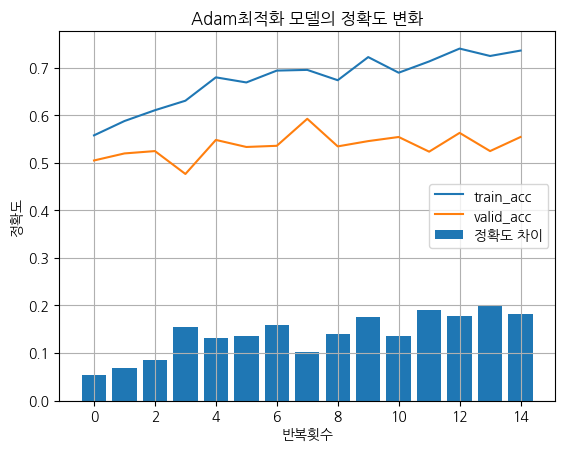

In [225]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.plot(train_acc, label="train_acc")
plt.plot(valid_acc, label="valid_acc")
plt.bar(range(15),train_acc-valid_acc, label="정확도 차이")
plt.legend()
plt.title("Adam최적화 모델의 정확도 변화")
plt.xlabel("반복횟수")
plt.ylabel("정확도")
plt.grid()
plt.show()

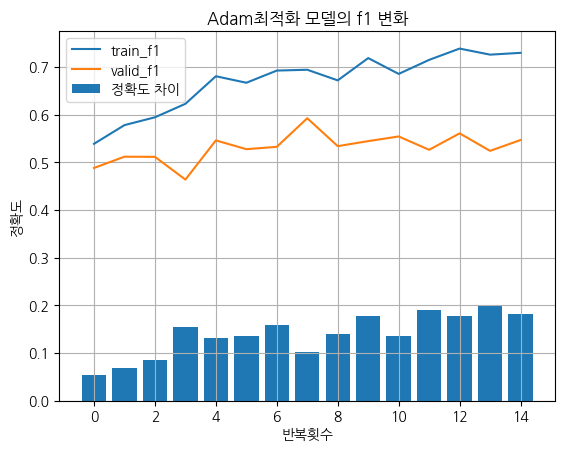

In [227]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.plot(train_f1, label="train_f1")
plt.plot(valid_f1, label="valid_f1")
plt.bar(range(15),train_acc-valid_acc, label="정확도 차이")
plt.legend()
plt.title("Adam최적화 모델의 f1 변화")
plt.xlabel("반복횟수")
plt.ylabel("정확도")
plt.grid()
plt.show()